In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import kagglehub

In [2]:
# Load and Inspect Dataset

path = kagglehub.dataset_download("nikhil1e9/loan-default")
df = pd.read_csv(f"{path}/Loan_default.csv")

print("Initial Shape:", df.shape)
df.info()

Using Colab cache for faster access to the 'loan-default' dataset.
Initial Shape: (255347, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPur

In [3]:
# Data Cleaning (Feature Engineering)

# Drop duplicates & remove ID column
df = df.drop_duplicates()
if 'LoanID' in df.columns:
    df = df.drop('LoanID', axis=1)

# Check missing values
print("\nMissing Values Count:", df.isnull().sum().sum())

# Quick statistics
print("\nData Summary:\n", df.describe().T)


Missing Values Count: 0

Data Summary:
                    count           mean           std      min       25%  \
Age             255347.0      43.498306     14.990258     18.0     31.00   
Income          255347.0   82499.304597  38963.013729  15000.0  48825.50   
LoanAmount      255347.0  127578.865512  70840.706142   5000.0  66156.00   
CreditScore     255347.0     574.264346    158.903867    300.0    437.00   
MonthsEmployed  255347.0      59.541976     34.643376      0.0     30.00   
NumCreditLines  255347.0       2.501036      1.117018      1.0      2.00   
InterestRate    255347.0      13.492773      6.636443      2.0      7.77   
LoanTerm        255347.0      36.025894     16.969330     12.0     24.00   
DTIRatio        255347.0       0.500212      0.230917      0.1      0.30   
Default         255347.0       0.116128      0.320379      0.0      0.00   

                      50%        75%       max  
Age                 43.00      56.00      69.0  
Income           82466.0

In [4]:
# Define Columns

num_cols = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
            'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']

cat_cols = ['Education', 'EmploymentType', 'MaritalStatus',
            'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']

target = 'Default'

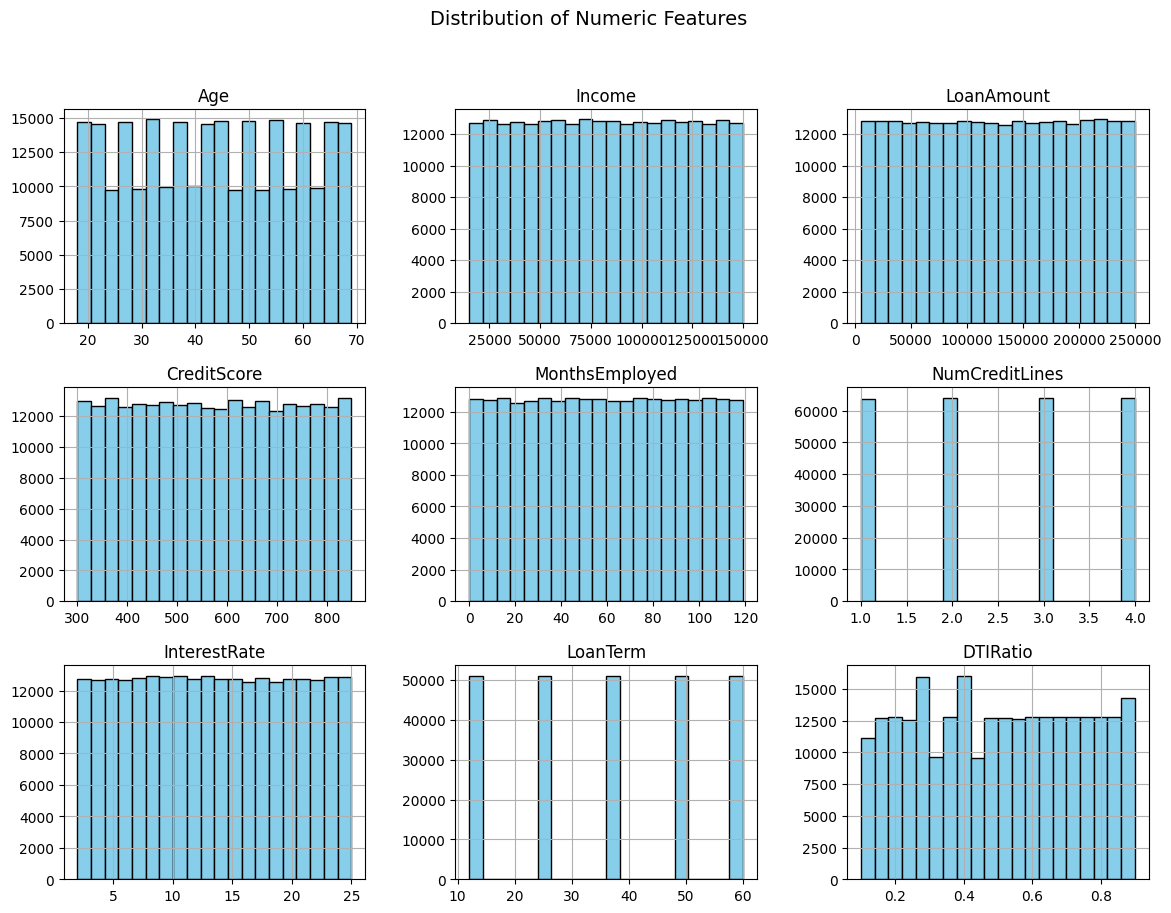

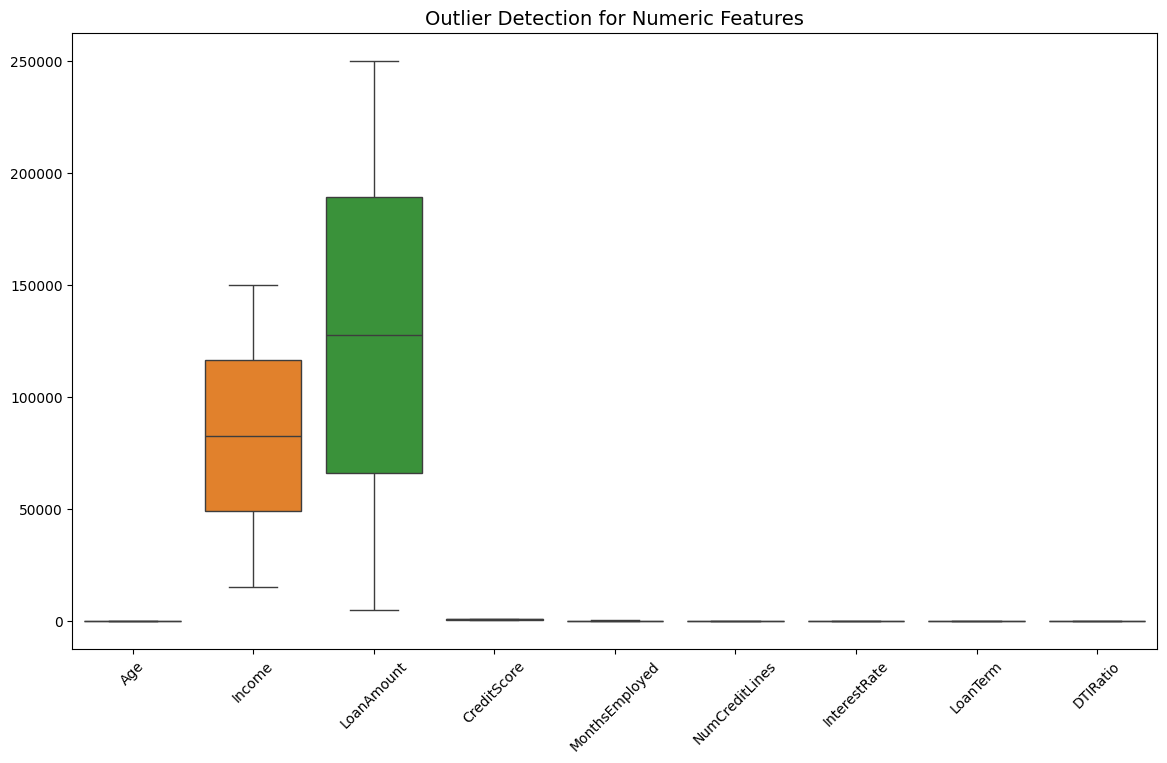

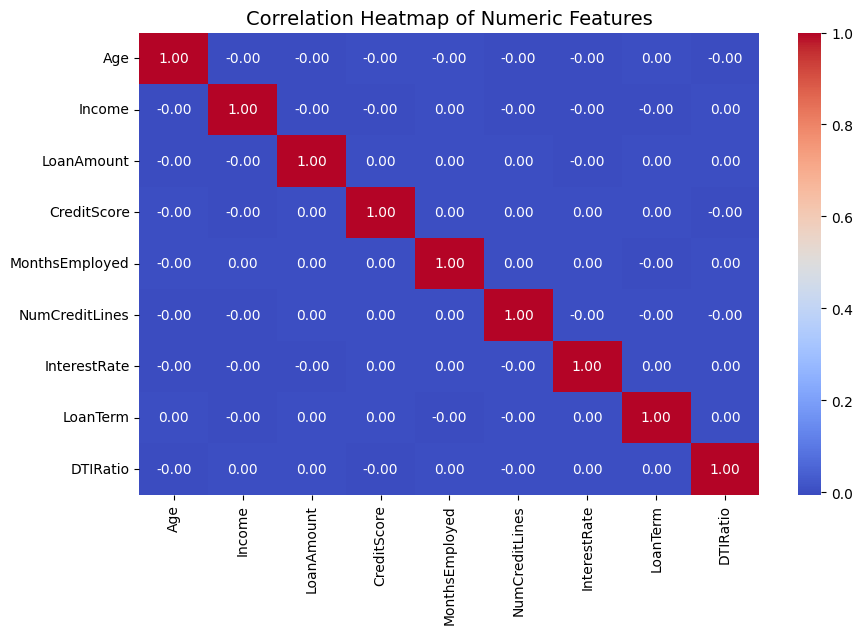

In [5]:
# EDA - Visualization Before Preprocessing


# Distribution of Numeric Features
df[num_cols].hist(bins=20, figsize=(14,10), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Numeric Features', fontsize=14)
plt.show()

# Outlier Detection (Boxplot)
plt.figure(figsize=(14,8))
sns.boxplot(data=df[num_cols])
plt.title("Outlier Detection for Numeric Features", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
plt.show()


In [6]:
# Split Train-Test

X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain size: {X_train.shape}, Test size: {X_test.shape}")
print(f"Defaulters in training: {(y_train.mean()*100):.2f}%")


Train size: (204277, 16), Test size: (51070, 16)
Defaulters in training: 11.61%


In [7]:
# Preprocessing (Encoding + Scaling)

# Numeric Transformer
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical Transformer
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine both into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

In [8]:
# Helper Function for Evaluation

def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n{name} Results:")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    return [acc, prec, rec, f1]

results = {}

In [9]:
#  Model 1 - Logistic Regression

log_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

log_pipeline.fit(X_train, y_train)
y_pred_log = log_pipeline.predict(X_test)
results['Logistic Regression'] = evaluate_model("Logistic Regression", y_test, y_pred_log)


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.94      0.67      0.79     45139
           1       0.22      0.70      0.33      5931

    accuracy                           0.68     51070
   macro avg       0.58      0.69      0.56     51070
weighted avg       0.86      0.68      0.73     51070

Confusion Matrix:
 [[30393 14746]
 [ 1781  4150]]


In [10]:
# Model 2 - Random Forest

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=300, max_depth=12, class_weight='balanced_subsample'))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
results['Random Forest'] = evaluate_model("Random Forest", y_test, y_pred_rf)


Random Forest Results:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87     45139
           1       0.27      0.54      0.36      5931

    accuracy                           0.78     51070
   macro avg       0.60      0.67      0.61     51070
weighted avg       0.85      0.78      0.81     51070

Confusion Matrix:
 [[36516  8623]
 [ 2724  3207]]


In [11]:
#  Model 3 - XGBoost

# Compute imbalance ratio for better training
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"\nClass Ratio (pos/neg): {scale_pos_weight:.2f}")

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss',
        random_state=42
    ))
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
results['XGBoost'] = evaluate_model("XGBoost", y_test, y_pred_xgb)


Class Ratio (pos/neg): 7.61

XGBoost Results:
              precision    recall  f1-score   support

           0       0.94      0.71      0.81     45139
           1       0.23      0.66      0.34      5931

    accuracy                           0.71     51070
   macro avg       0.59      0.69      0.58     51070
weighted avg       0.86      0.71      0.76     51070

Confusion Matrix:
 [[32252 12887]
 [ 2016  3915]]


In [12]:
# Model Comparison Table

df_results = pd.DataFrame(results).T
df_results.columns = ['Accuracy', 'Precision', 'Recall', 'F1']
df_results = (df_results * 100).round(2)

print("\n Model Comparison (%):")
display(df_results)



 Model Comparison (%):


,Accuracy,Precision,Recall,F1
Logistic Regression,67.64,21.96,69.97,33.43
Random Forest,77.78,27.11,54.07,36.11
XGBoost,70.82,23.30,66.01,34.44


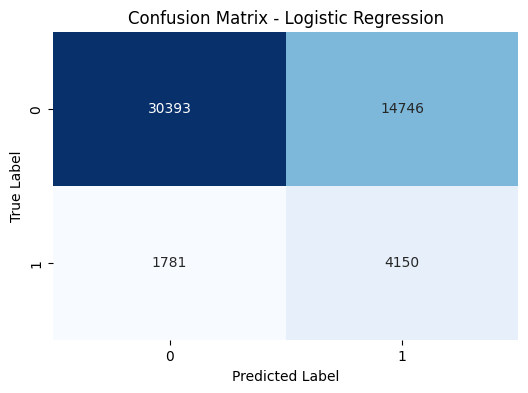

In [13]:
# Confusion Matrix for Logistic Regression
cm = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

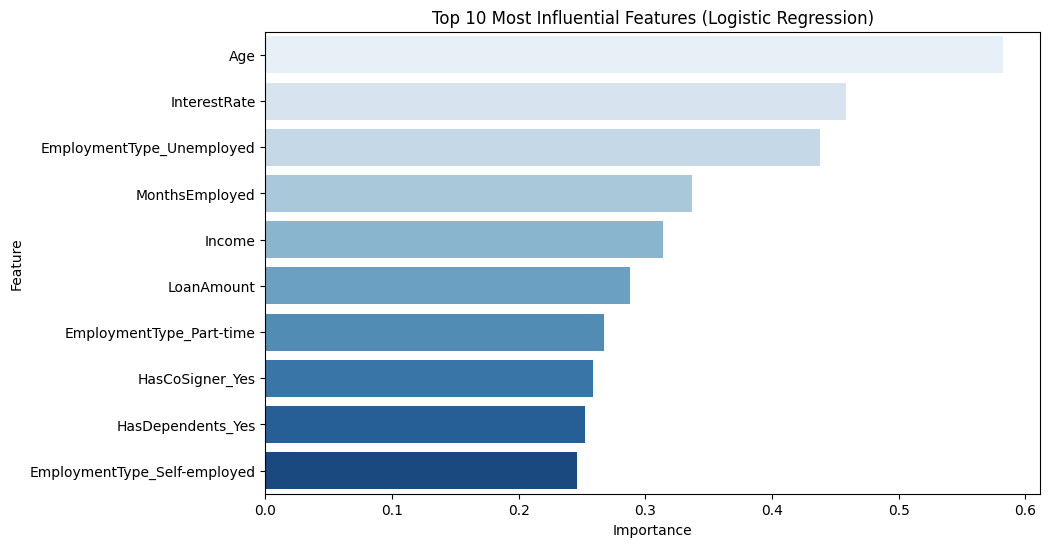

In [14]:
#Top Predictive Features

encoded_feature_names = (
    num_cols +
    list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_cols))
)

feature_importance = pd.DataFrame({
    'Feature': encoded_feature_names,
    'Importance': abs(log_pipeline.named_steps['classifier'].coef_[0])
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='Blues')
plt.title('Top 10 Most Influential Features (Logistic Regression)')
plt.show()